The dataset needs to be a stack of raw images.

The labels need to be a stack of binary masks.

The graph needs to be a valid tensorflow graph.

The spec needs to be a dictionary.

The preprocessing function needs to accept the raw images and labels and return the filtered and subset images with their associated one-hot encoded labels.

In [11]:
from scipy.misc import imread, imresize
from pymvtest import classification
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import numpy as np
%matplotlib inline

### 1. Import raw images.

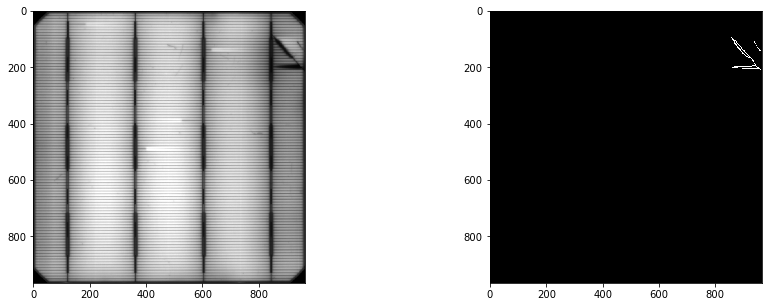

In [12]:
images = np.array([np.expand_dims(imread(fp), axis = -1) for fp in glob('../data/resized-images/*.png')])
masks  = np.array([imread(fp)/255 for fp in glob('../data/masked-images/*.png')])
_, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(images[20, :, :].squeeze(), cmap = 'gray'); axs[1].imshow(masks[20], cmap = 'gray');

### 2. Define a preprocessing sequence

1. Resize images to $200 \times 200$.
2. Resize masks to $200 \times 200$ (bilinear interpolation).
3. Threshold resized masks.
4. Extract a shuffled, balanced set of $20 \times 20$ image patches for training.
5. Extract an imbalanced set of $20 \times 20$ image patches for testing.
6. Whiten the subset images (subtract pixel means, scale by pixel std.). Store the training values for use at testing time.
7. One-hot encode the patch masks - a patch's class is determined by the class of its central pixel.
8. Cast both the labels and the images to np.float32 arrays.

In [13]:
np.logical_not(np.array([True, False, True]))

array([False,  True, False], dtype=bool)

In [14]:
def extract_patches(images, masks, patch_size, mode):
    """
    Extracts patches from image data. If training, returns a balanced set of patches.
    If testing, returns patches for every pixel in every image passed.
    
    Args:
        images:     np.float32 array of images.
        masks:      np.float32 array of by-pixel class masks.
        patch_size: integer indicating kernel side length.
        train:      bool indicating whether to return a balanced dataset.
        
    Returns:
        patches:    np.float32 of subset images.
        ohe_labels: np.float32 array of one-hot encoded by-pixel image labels
    """
    ps = patch_size
    
    if (mode == 'train') or (mode == 'valid'):
        ix = {'crack' : np.array(np.nonzero(masks)).T,
              'nocrack' : np.array(np.nonzero(np.logical_not(masks))).T}
        
        ix['nocrack'] = ix['nocrack'][np.random.randint(low = 0,
                                                        high = ix['nocrack'].shape[0],
                                                        size = ix['crack'].shape[0]),
                                      :]
        ix = np.concatenate([ix['crack'], ix['nocrack']], axis = 0)
        
    elif mode == 'test':
        ix = np.array(np.nonzero(masks != None)).T
        
    patches    = np.zeros([ix.shape[0], patch_size, patch_size, 1])
    ohe_labels = np.zeros([ix.shape[0], 2])
    
    # Sample patches at the chosen pixels
    for j, i in enumerate(np.random.permutation(ix)):
        
        if (j == 0) or np.any(images[i[0], :, :, :] != img):
            img  = images[i[0], :, :, :]
            pimg = np.pad(img, pad_width = [[ps, ps], [ps, ps], [0, 0]],
                          mode = 'constant', constant_values = 0)
            
        patches[j, :, :, :] =  pimg[i[0] + ps // 2 : i[0] + (3 * ps // 2),
                                    i[1] + ps // 2 : i[1] + (3 * ps // 2)] # Extract patch of image centered on the ith pixel
        k = masks[i[0], i[1], i[2]]
        ohe_labels[j, int(k)] = 1.
    
    return patches, ohe_labels

In [15]:
def preprocessing(self, dataset, masks, mode):
    """
    Extracts and whitens patches. Designed in accordance with Tester requirements.
    
    Arguments:
        dataset: np.float32 array of images.
        labels:  np.float32 array of by-pixel masks for the images.
        train:   bool indicating whether to balance dataset and store filter parameters.
        
    Returns:
        filtered_dataset: subset images.
        filtered_labels:  one-hot encoded labels
    """
    # Resizing
    IMAGE_SIZE      = 200
    MASK_THRESHOLD  = 0.2
    resized_dataset = np.array([imresize(img.squeeze(), [IMAGE_SIZE, IMAGE_SIZE]) for img in dataset])
    resized_masks   = np.array([imresize(msk, [IMAGE_SIZE, IMAGE_SIZE]) for msk in masks])
    resized_masks   = np.greater(resized_masks, MASK_THRESHOLD*255)
    
    resized_dataset = np.expand_dims(resized_dataset, axis = -1)
    
    # Subsetting
    PATCH_SIZE     = 20
    
    # Filtering
    if mode == 'train':
        subset_dataset, subset_labels  = extract_patches(resized_dataset,
                                                         resized_masks, PATCH_SIZE, mode = 'train') # Balanced subset
        self.pp_parameters['mean'] = np.mean(subset_dataset, axis = 0)
        self.pp_parameters['std']  = np.std(subset_dataset, axis = 0)
        print('Training dataset dimensions: {}'.format(subset_dataset.shape))
        print('Training labels dimensions: {}'.format(subset_labels.shape))
        
    elif mode == 'valid':
        subset_dataset, subset_labels  = extract_patches(resized_dataset,
                                                         resized_masks, PATCH_SIZE, mode = 'valid')
        print('Validation dataset dimensions: {}'.format(subset_dataset.shape))
        print('Validation labels dimensions: {}'.format(subset_labels.shape))
    
    filtered_dataset = (subset_dataset.astype(np.float32) 
                            - self.pp_parameters['mean'])/self.pp_parameters['std']
    filtered_labels  = subset_labels.astype(np.float32)

    return filtered_dataset, filtered_labels

### 3. Define a model in the form of a TensorFlow graph.

A 2-layer convolutional neural network accepting a $20 \times 20 \times 1$ input image and returning one-hot encoded prediction labels.

Must use namespaces:
- `tf_train_data`
- `tf_train_labels`
- `tf_train_predictions`
- `optimizer`
- `loss`
- `tf_test_predictions`

In [16]:
# 2-layer graph accepting a 20x20 input

image_size      = 20
n_channels      = 1
n_classes       = 2
batch_size      = 32
output_channels = [64, 128, 1024] # By layer
filter_size     = [3, 3] # By layer

simple_graph = tf.Graph()

with simple_graph.as_default():
    # Placeholders and constants
    tf_train_data   = tf.placeholder(tf.float32, [batch_size, image_size, image_size, n_channels],
                                     name = 'tf_train_data') # BWHN
    tf_train_labels = tf.placeholder(tf.float32, [batch_size, n_classes],
                                     name = 'tf_train_labels')
    tf_test_data    = tf.placeholder(tf.float32, [None, image_size, image_size, n_channels],
                                     name = 'tf_test_data')
    
    # Variables
    filters1 = tf.Variable(tf.truncated_normal(
                    [filter_size[0], filter_size[0], n_channels, output_channels[0]], stddev = 0.01))
    biases1  = tf.Variable(tf.zeros([output_channels[0]]))
    
    filters2 = tf.Variable(tf.truncated_normal(
                    [filter_size[1], filter_size[1], output_channels[0], output_channels[1]], stddev = 0.01))
    biases2  = tf.Variable(tf.zeros([output_channels[1]]))
    
    weights3 = tf.Variable(tf.truncated_normal(
                    [output_channels[1] * image_size * image_size, n_classes], stddev = 0.01))
    biases3  = tf.Variable(tf.zeros(n_classes))
    
    def model(data):
        # Layer 1 : 20 x 20 x 1 input ; 10 x 10 x 64 output ; (3 x 3 x 1) x 64 filters ; stride of 2 ; same padding
        conv = tf.nn.conv2d(data, filters1, strides = [1, 1, 1, 1], padding = 'SAME', use_cudnn_on_gpu = True)
        act  = tf.nn.relu(conv + biases1)
        
        # Layer 2 : 10 x 10 x 64 input ; 5 x 5 x 128 output ; (3 x 3 x 64) x 128 filters ; stride of 2 ; same padding
        conv = tf.nn.conv2d(act, filters2, strides = [1, 1, 1, 1], padding = 'SAME', use_cudnn_on_gpu = True)
        act  = tf.nn.relu(conv + biases2)
        
        # layer 3 : fully connected ; 5*5*128 input ; (5*5*128 x 2) filters
        shape  = tf.shape(act)
        act    = tf.reshape(act, [shape[0], shape[1]*shape[2]*shape[3]])
        logits = tf.nn.relu(tf.matmul(act, weights3) + biases3)
        return logits
    
    # Loss and optimizer
    logits = model(tf_train_data)
    loss   = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels),
                name = 'loss')
    optimizer = tf.train.GradientDescentOptimizer(0.1, name = 'optimizer').minimize(loss)
    
    # Feedback information
    tf_train_predictions = tf.nn.softmax(logits, name = 'tf_train_predictions')
    tf_test_predictions  = tf.nn.softmax(model(tf_test_data), name = 'tf_test_predictions')

### 4. Define a testing specification.

In [17]:
spec = {'mode':'holdout', 'seed':1,
        'n_train':1000, 'batch_size':batch_size,
        'training_steps':1000}

### 5. Test the model.

In [18]:
tester = classification.Tester(dataset = images,
                               masks = masks, 
                               graph = simple_graph,
                               spec = spec,
                               preprocessor = preprocessing)

Holdout testing mode initialized.

Splitting images by class content...
Dataset split.

Dataset 	 Dim. 	 Mem. Usage
Train  	 (47, 965, 965, 1) 	 043.77MB
Validation   	 (5, 965, 965, 1) 	 004.66MB
Preprocessing training data... 
Training dataset dimensions: (4490, 20, 20, 1)
Training labels dimensions: (4490, 2)
Training data preprocessed.
Preprocessing validation data... 
Validation dataset dimensions: (78, 20, 20, 1)
Validation labels dimensions: (78, 2)
Validation data preprocessed.
Dataset 	 Dim. 	 Mem. Usage
PTrain  	 (4490, 20, 20, 1) 	 014.37MB
PValid   	 (78, 20, 20, 1) 	 000.25MB


In [19]:
tester.graph = simple_graph
tester.evaluate_model()


Fitting model...

Step 0
----------
Minibatch accuracy: 59.38%
Minibatch loss: 0.6928
[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]

Validation accuracy: 50.00%

Step 100
----------
Minibatch accuracy: 59.38%
Minibatch loss: 0.6931
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]

Validation accuracy: 50.00%

Step 200
----------
Minibatch accuracy: 46.88%
Minibatch loss: 0.6931
[[ 0.  

KeyboardInterrupt: 